# NationStates Data Analysis (now with Epoch / Time of Data Extraction)

### For future use with .txt files. Do not use CSV or XLSX because Excel botches it up!

In [15]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import numpy as np
import pandas as pd
import time
import scipy
import random
import operator
import os
import string
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter, ScalarFormatter, MultipleLocator, AutoMinorLocator, LogLocator, LogFormatterSciNotation
from matplotlib.ticker import Locator
from matplotlib.pyplot import figure

from matplotlib.colors import LogNorm
import matplotlib.colors as colors

import matplotlib.cbook as cbook
import matplotlib.font_manager as font_manager

import math

from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [16]:
# Global parameters. Mainly for the graphs.

# plt.rcParams['font.family'] = 'Iosevka Custom'
# plt.rcParams['font.family'] = 'Blender Pro Medium'
# plt.rcParams['font.family'] = 'Arial'

plt.rcParams['font.family'] = 'Iosevka'
# plt.rcParams['font.family'] = 'Fixedsys Excelsior 3.01'
plt.rcParams.update({'font.size': 24})

pd.set_option("display.max_columns", 400)
# pd.set_option("display.min_columns", 400)
pd.set_option("display.max_rows", 20)
pd.set_option('display.min_rows', 20)
pd.set_option('display.expand_frame_repr', True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [17]:
# Additional Functions that are required for later.

# Credit: ImportanceOfBeingErnest, https://stackoverflow.com/questions/43324152/python-matplotlib-colorbar-scientific-notation-base
class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

# --------------------------------------------------------------------------
# Credit: unutbu, https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# --------------------------------------------------------------------------
# Credit: David Zwicker and Matt Pitkin, https://stackoverflow.com/questions/20470892/how-to-place-minor-ticks-on-symlog-scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

In [18]:
# Initiate headers.

folder = "data"
file_name = "All Nations - 2022-01-30 184511 (Sample).txt"
file_path = os.path.join(folder, file_name)

with open(file_path) as f:
    lines = f.readlines()
    
headers = lines[0][:-1].replace("[", "").replace("]", "").replace("\'", "").replace(", ", ",").split(",")

# -----------------------------------------

# Add the rest of the nations...

super_list = []

for i in range(1, len(lines)):
    one_nation_data = []

    one_nation = (lines[i][:-1]).replace("\'", "")[1:-1].replace(", ", ",").replace("[", "").replace("]", "").split(",")

    one_nation_data = one_nation[0:229]
    
    policy_name = one_nation[229:229+int(((len(one_nation[229:]))-1)/4)]  
    policy_code = one_nation[229+1*int(((len(one_nation[229:]))-1)/4):229+2*int(((len(one_nation[229:]))-1)/4)]
    policy_category = one_nation[229+2*int(((len(one_nation[229:]))-1)/4):229+3*int(((len(one_nation[229:]))-1)/4)]
    policy_descript = one_nation[229+3*int(((len(one_nation[229:]))-1)/4):229+4*int(((len(one_nation[229:]))-1)/4)]

    
    one_nation_data.append(policy_name)
    one_nation_data.append(policy_code)
    one_nation_data.append(policy_category)
    one_nation_data.append(policy_descript)
    
    one_nation_data.append(one_nation[-1])

    super_list.append(one_nation_data)

    
df1 = pd.DataFrame(super_list, columns = list(headers))
df1 = df1.dropna()
df1 = df1.apply(pd.to_numeric, errors = 'ignore')

display(df1)

,Nation Name,Category,Number of Issues Answered,Region Name,Flag,Percentage Government Expenditure: Administration,Percentage Government Expenditure: Defence,Percentage Government Expenditure: Education,Percentage Government Expenditure: Environment,Percentage Government Expenditure: Healthcare,Percentage Government Expenditure: Commerce,Percentage Government Expenditure: International Aid,Percentage Government Expenditure: Law and Order,Percentage Government Expenditure: Public Transport,Percentage Government Expenditure: Social Equality,Percentage Government Expenditure: Spirituality,Percentage Government Expenditure: Welfare,Percentage Market Sector: Black Market,Percentage Market Sector: Government,Percentage Market Sector: Industry,Percentage Market Sector: Public,Percentage Death Type: Accident,Percentage Death Type: Acts of God,Percentage Death Type: Animal Attack,Percentage Death Type: Bungee Jumping,Percentage Death Type: Capital Punishment,Percentage Death Type: Cancer,Percentage Death Type: Disappearance,Percentage Death Type: Exposure,Percentage Death Type: Heart Disease,Percentage Death Type: Involuntary Euthanasia,Percentage Death Type: Lost in Wilderness,Percentage Death Type: Malnourishment,Percentage Death Type: Murder,Percentage Death Type: Nuclear Spill,Percentage Death Type: Old Age,Percentage Death Type: Ritual Sacrifice,Percentage Death Type: Scurvy,Percentage Death Type: Space Shuttle Mishap,Percentage Death Type: Suicide While in Police Custody,Percentage Death Type: Sunburn,Percentage Death Type: Vat Leakage,Percentage Death Type: War,Percentage Death Type: Work,civil rights,civil rights rank,economy,economy rank,political freedoms,political freedoms rank,population,population rank,wealth gaps,wealth gaps rank,death rate,death rate rank,compassion,compassion rank,eco-friendliness,eco-friendliness rank,social conservatism,social conservatism rank,nudity,nudity rank,industry: automobile manufacturing,industry: automobile manufacturing rank,industry: cheese exports,industry: cheese exports rank,industry: basket weaving,industry: basket weaving rank,industry: information technology,industry: information technology rank,industry: pizza delivery,industry: pizza delivery rank,industry: trout fishing,industry: trout fishing rank,industry: arms manufacturing,industry: arms manufacturing rank,sector: agriculture,sector: agriculture rank,industry: beverage sales,industry: beverage sales rank,industry: timber woodchipping,industry: timber woodchipping rank,industry: mining,industry: mining rank,industry: insurance,industry: insurance rank,industry: furniture restoration,industry: furniture restoration rank,industry: retail,industry: retail rank,industry: book publishing,industry: book publishing rank,industry: gambling,industry: gambling rank,sector: manufacturing,sector: manufacturing rank,government size,government size rank,welfare,welfare rank,public healthcare,public healthcare rank,law enforcement,law enforcement rank,business subsidization,business subsidization rank,religiousness,religiousness rank,income equality,income equality rank,niceness,niceness rank,rudeness,rudeness rank,intelligence,intelligence rank,ignorance,ignorance rank,political apathy,political apathy rank,health,health rank,cheerfulness,cheerfulness rank,weather,weather rank,compliance,compliance rank,safety,safety rank,lifespan,lifespan rank,ideological radicality,ideological radicality rank,defense forces,defense forces rank,pacifism,pacifism rank,economic freedom,economic freedom rank,taxation,taxation rank,freedom from taxation,freedom from taxation rank,corruption,corruption rank,integrity,integrity rank,authoritarianism,authoritarianism rank,youth rebelliousness,youth rebelliousness rank,culture,culture rank,employment,employment rank,public transport,public transport rank,tourism,tourism rank,weaponization,weaponization rank,recreational drug use,recreational drug use rank,obesity,obesity rank,secularism,secularism rank,environment

In [19]:
# Extra headers for other attributes of a nation. Some were from API, some were calculated.
# These can be done inside the .csv files with Excel forumlas, but Python is definitely A LOT faster.

# Data augmentation / Getting more data from the ones we have gathered.

govt_expenditure_list = ["Percentage Government Expenditure: Administration",
"Percentage Government Expenditure: Defence",
"Percentage Government Expenditure: Education",
"Percentage Government Expenditure: Environment",
"Percentage Government Expenditure: Healthcare",
"Percentage Government Expenditure: Commerce",
"Percentage Government Expenditure: International Aid",
"Percentage Government Expenditure: Law and Order",
"Percentage Government Expenditure: Public Transport",
"Percentage Government Expenditure: Social Equality",
"Percentage Government Expenditure: Spirituality",
"Percentage Government Expenditure: Welfare"]

govt_expenditure_list_absolute = ["Absolute Government Expenditure: Administration",
"Absolute Government Expenditure: Defence",
"Absolute Government Expenditure: Education",
"Absolute Government Expenditure: Environment",
"Absolute Government Expenditure: Healthcare",
"Absolute Government Expenditure: Commerce",
"Absolute Government Expenditure: International Aid",
"Absolute Government Expenditure: Law and Order",
"Absolute Government Expenditure: Public Transport",
"Absolute Government Expenditure: Social Equality",
"Absolute Government Expenditure: Spirituality",
"Absolute Government Expenditure: Welfare"]

# ---------------------

market_list = ["Percentage Market Sector: Black Market",
"Percentage Market Sector: Government",
"Percentage Market Sector: Industry",
"Percentage Market Sector: Public"]

market_list_absolute = ["Absolute Market Sector: Black Market",
"Absolute Market Sector: Government",
"Absolute Market Sector: Industry",
"Absolute Market Sector: Public"]
    
# ---------------------

death_types = ["Percentage Death Type: Accident",
"Percentage Death Type: Acts of God",
"Percentage Death Type: Animal Attack",
"Percentage Death Type: Bungee Jumping",
"Percentage Death Type: Capital Punishment",
"Percentage Death Type: Cancer",
"Percentage Death Type: Disappearance",
"Percentage Death Type: Exposure",
"Percentage Death Type: Heart Disease",
"Percentage Death Type: Involuntary Euthanasia",
"Percentage Death Type: Lost in Wilderness",
"Percentage Death Type: Malnourishment",
"Percentage Death Type: Murder",
"Percentage Death Type: Nuclear Spill",
"Percentage Death Type: Old Age",
"Percentage Death Type: Ritual Sacrifice",
"Percentage Death Type: Scurvy",
"Percentage Death Type: Space Shuttle Mishap",
"Percentage Death Type: Suicide While in Police Custody",
"Percentage Death Type: Sunburn",
"Percentage Death Type: Vat Leakage",
"Percentage Death Type: War",
"Percentage Death Type: Work"]

death_types_absolute = ["Absolute Death Type: Accident",
"Absolute Death Type: Acts of God",
"Absolute Death Type: Animal Attack",
"Absolute Death Type: Bungee Jumping",
"Absolute Death Type: Capital Punishment",
"Absolute Death Type: Cancer",
"Absolute Death Type: Disappearance",
"Absolute Death Type: Exposure",
"Absolute Death Type: Heart Disease",
"Absolute Death Type: Involuntary Euthanasia",
"Absolute Death Type: Lost in Wilderness",
"Absolute Death Type: Malnourishment",
"Absolute Death Type: Murder",
"Absolute Death Type: Nuclear Spill",
"Absolute Death Type: Old Age",
"Absolute Death Type: Ritual Sacrifice",
"Absolute Death Type: Scurvy",
"Absolute Death Type: Space Shuttle Mishap",
"Absolute Death Type: Suicide While in Police Custody",
"Absolute Death Type: Sunburn",
"Absolute Death Type: Vat Leakage",
"Absolute Death Type: War",
"Absolute Death Type: Work"]
    
industry_list = ["industry: automobile manufacturing",
"industry: cheese exports",
"industry: basket weaving",
"industry: information technology",
"industry: pizza delivery",
"industry: trout fishing",
"industry: arms manufacturing",
"sector: agriculture",
"industry: beverage sales",
"industry: timber woodchipping",
"industry: mining",
"industry: insurance",
"industry: furniture restoration",
"industry: retail",
"industry: book publishing",
"industry: gambling",
"sector: manufacturing",
"tourism"]

industry_list_normalized = ["Normalized industry: automobile manufacturing",
"Normalized industry: cheese exports",
"Normalized industry: basket weaving",
"Normalized industry: information technology",
"Normalized industry: pizza delivery",
"Normalized industry: trout fishing",
"Normalized industry: arms manufacturing",
"Normalized sector: agriculture",
"Normalized industry: beverage sales",
"Normalized industry: timber woodchipping",
"Normalized industry: mining",
"Normalized industry: insurance",
"Normalized industry: furniture restoration",
"Normalized industry: retail",
"Normalized industry: book publishing",
"Normalized industry: gambling",
"Normalized sector: manufacturing",
"Normalized tourism"]

industry_list_rank = ["industry: automobile manufacturing rank",
"industry: cheese exports rank",
"industry: basket weaving rank",
"industry: information technology rank",
"industry: pizza delivery rank",
"industry: trout fishing rank",
"industry: arms manufacturing rank",
"sector: agriculture rank",
"industry: beverage sales rank",
"industry: timber woodchipping rank",
"industry: mining rank",
"industry: insurance rank",
"industry: furniture restoration rank",
"industry: retail rank",
"industry: book publishing rank",
"industry: gambling rank",
"sector: manufacturing rank",
"tourism rank"]

df1["adjusted economic freedom"] = np.where(df1['economic freedom'] < 0, df1['economic freedom'] + 100, df1['economic freedom'])

# Softness Index: Determines how soft and compassionate a nation is.
softness_index_components = ["compassion", "niceness", "cheerfulness", "inclusiveness"]
softness_index_components_rank = ["compassion rank", "niceness rank", "cheerfulness rank", "inclusiveness rank"]

# More humorously titled Dakka Index: Determines how much weapons does a nation has.
dakka_index_components = ["weaponization", "industry: arms manufacturing", "defense forces"]
dakka_index_components_rank = ["weaponization rank", "industry: arms manufacturing rank", "defense forces rank"]

# Public Services Total: Sum of 3 public services.
public_services_total = ["public healthcare", "public transport", "public education"]
public_services_total_rank = ["public healthcare rank", "public transport rank", "public education rank"]

# Militant Pacifism Index: Defense Forces + Pacifism, just to see how much can a nation have both.
militant_pacifism_components = ["defense forces", "pacifism"]
militant_pacifism_components_rank = ["defense forces rank", "pacifism rank"]

# Total Government Expenditure. As defined: Economic Output * Government Market %
df1["Total Government Expenditure"] = df1["Percentage Market Sector: Government"] / 100 * df1["economic output"]

# Absolute Government Expenditure: Multiplies (Average Income - Average Disposable Income) by each of the Percentage Government Expenditure.
# For example: Absolute Healthcare Expenditure = Amount the Govt takes, multiplied by Percentage Healthcare Expenditure
for i in range(len(govt_expenditure_list_absolute)):
    df1[str(govt_expenditure_list_absolute[i])] = df1[govt_expenditure_list[i]] / 100 * df1["Total Government Expenditure"]

# Same function as above, but with Market List.
for i in range(len(market_list_absolute)):
    df1[str(market_list_absolute[i])] = df1[market_list[i]] / 100 * df1["economic output"]

# Same function as above, but with Causes of Death.
for i in range(len(death_types_absolute)):
    df1[str(death_types_absolute[i])] = df1[death_types[i]] / 100 * df1["death rate"]

# Same function as above, but with Industry List.
for i in range(len(industry_list_normalized)):
    df1[str(industry_list_normalized[i])] = (df1[industry_list[i]] - df1[industry_list[i]].min()) / (df1[industry_list[i]].max() - df1[industry_list[i]].min())

# TODO: There is definitely a way to nest this further, but I am putting this off for later.

# --------------------------------------------------------------------------
# Combined Industries Index Consists of 15 industries + 2 sectors + Tourism.
df1["Combined Industries Index"] = 0
for i in range(len(industry_list_normalized)):
    df1["Combined Industries Index"] += df1[industry_list_normalized[i]]

df1["Combined Industries World Rank"] = 0
for i in range(len(industry_list_rank)):
    df1["Combined Industries World Rank"] += df1[industry_list_rank[i]]

# NationStates uses Income Equality that is rounded to 2 d.p. We can calculate the more precise value using Poor / Rich * 100.
df1["Precise Income Equality"] = (df1["average income of poor"] / df1["average income of rich"]) * 100

# Same as Income Equality, but the inverse.
df1["Precise Wealth Gap"] = df1["average income of rich"] / df1["average income of poor"]

# Sum of 3 Rights = Civil Rights + Political Freedoms + Economic Freedom (EF).
df1["Sum of 3 Rights"] = df1["civil rights"] + df1["political freedoms"] + ((df1["economic freedom"] + 100) / 2)

df1["Civil + Political Rights"] = df1["civil rights"] + df1["political freedoms"]

# Adjusted Economic Freedom (AEF) is EF that is narrowed to 0-100 instead of (-100) to (+100). AEF is calculated in Excel.
# Credits to SherpDaWerp for the Adjusted Economic Freedom idea; Add 100 if EF < 0, otherwise keep it as it is.
df1["Sum of 3 Rights (w/ Adjusted Economic Freedom)"] = df1["civil rights"] + df1["adjusted economic freedom"] + df1["political freedoms"] # Credits: SherpDaWerp - Adjusted Economic Freedom: +100 if EF < 0. 

# Normalization is done because each of the stats have differing min-max from one another.
df1["Normalized Nation Softness Index"] = 0
for i in range(len(softness_index_components)):
    df1["Normalized Nation Softness Index"] += (df1[softness_index_components[i]] - df1[softness_index_components[i]].min()) / (df1[softness_index_components[i]].max() - df1[softness_index_components[i]].min())

df1["Global Nation Softness Rank"] = 0
for i in range(len(softness_index_components_rank)):
    df1["Global Nation Softness Rank"] += df1[softness_index_components_rank[i]]
    
df1["Normalized Dakka Index"] = 0
for i in range(len(dakka_index_components)):
    df1["Normalized Dakka Index"] += (df1[dakka_index_components[i]] - df1[dakka_index_components[i]].min()) / (df1[dakka_index_components[i]].max() - df1[dakka_index_components[i]].min())

df1["Global Dakka Rank"] = df1[dakka_index_components_rank[0]] + df1[dakka_index_components_rank[1]] + df1[dakka_index_components_rank[2]]

df1["Militant Pacifism Score"] = df1[militant_pacifism_components[0]] * df1[militant_pacifism_components[1]]

df1["Global Militant Pacifism Rank"] = df1[militant_pacifism_components_rank[0]] + df1[militant_pacifism_components_rank[1]]

df1["Black Market Prevalence"] = df1["black market"] / (df1["economic output"]+1)

df1["Public Services Index"] = 0
for i in range(len(public_services_total)):
    df1["Public Services Index"] += (df1[public_services_total[i]] - df1[public_services_total[i]].min()) / (df1[public_services_total[i]].max() - df1[public_services_total[i]].min())

df1["Public Services Index Rank"] = 0
for i in range(len(public_services_total_rank)):
    df1["Public Services Index Rank"] += (df1[public_services_total_rank[i]] - df1[public_services_total_rank[i]].min()) / (df1[public_services_total_rank[i]].max() - df1[public_services_total_rank[i]].min())

# # Mapping Regions to an assigned ID. This is useful if we are calculating densities.
# Region_List = list(df1["Region Name"])
# Region_List = list(set(Region_List))
# # Region_List.sort()
# Region_Index = { Region_List[i] : i for i in range(0, len(Region_List)) }
# df1['Region Index'] = df1['Region Name'].map(Region_Index)

# # Mapping WA Category to an assigned ID. This is useful if we are calculating densities.
# Category_List = list(df1["Category"])
# Category_List = list(set(Category_List))
# Category_List.sort()
# Category_Index = { Category_List[i] : i for i in range(0, len(Category_List)) }
# df1['Category Index'] = df1['Category'].map(Category_Index)

df1["Nation Count"] = 1 # Used mainly for regional and categorical aspects, i.e. totalling region and category counts.

# Greenness Index first thought of by NationStates' user - Ransium.
df1["Greenness Index"] = (df1["environmental beauty"] / 22500 * 0.75) + (df1["weather"] / 4200 * 0.25) + (df1["tourism"] / 10000 * 0.25) + (df1["eco-friendliness"] / 60000 * 0.20) + ((df1["lifespan"] / 105)**2 * 0.10) + (df1["public transport"] / 28000 * 0.05)

df1["First Letter"] = df1["Nation Name"].astype(str).str[0]

df1 = df1.dropna()
df1 = df1.reset_index(drop = True)

In [20]:
df1 = df1.apply(pd.to_numeric, errors = 'ignore')

In [21]:
policy = "Atheism"

policy_values = []

for i in range(0, len(df1)):
    if policy in df1['Policies Name List'][i]:
        policy_values.append(1)
    else:
        policy_values.append(0)
        
policy_table = pd.DataFrame(policy_values, columns = ["Existence of " + str(policy)])

try:
    df1 = df1.join(policy_table)
except:
    pass

df1 = df1.apply(pd.to_numeric, errors = 'ignore')

In [22]:
# Individual nations analysis. Make a smaller table with proper headers.

# Make data. Choose the stats you want here. Some are capitalised, some are all small letters. Look up the table above and scroll to find the header.
x = 'population'
y = 'residency'
z = 'Number of Issues Answered'

xrank = x + " rank"
yrank = y + " rank"
zrank = z + " rank"

X = df1[x]
Y = df1[y]
Z = df1[z]

XLin = string.capwords(x) + " (X, Linear)"
YLin = string.capwords(y) + " (Y, Linear)"
ZLin = string.capwords(z) + " (Z, Linear)"

XLog = string.capwords(x) + " (X, Log)"
YLog = string.capwords(y) + " (Y, Log)"
ZLog = string.capwords(z) + " (Z, Log)"

deg = 1

df2 = pd.DataFrame({
    "Short Name of the Nation (no pretitle)": df1["Nation Name"],
    "Region": df1["Region Name"],
    "Population of Nation": df1["population"],
    "Category": df1["Category"],
    "Number of Issues Answered": df1["Number of Issues Answered"],
    "Time of Extraction" : (pd.to_datetime(df1["Time of Extraction"], unit = 's')).dt.round('1s'),

    x + " (x)" : X, 
    y + " (y)" : Y,  
    z + " (z)" : Z,
    

                   })
    

# ------------------ Sort and filter / cut off

# Random sorting is useful if you don't want to include in biases from "First in, last out."
# df2 = df2.reindex(np.random.permutation(df2.index))

# Otherwise, you can use this to sort ascending/descending for a particular column. Defaults to the rightmost column [-1].
df2.sort_values(by = df2.columns[-1], inplace = True, ascending = True)

# The name must have a single dumb quote ' behind for older data files. Spaces must still be underscored.
Filter_list = list(df2[df2["Region"] == "World of Beetles"]["Short Name of the Nation (no pretitle)"])

# Filtering. Add more if needed.

# df2 = df2[df2["Short Name of the Nation (no pretitle)"].str.len() == 2]
# df2 = df2[(X <= 25)]
# df2 = df2[(Y <= 60)]
# df2 = df2[Z == 1]

# df2 = df2[(df2["Category"].str.contains("Psy"))]

# df2 = df2[(df2["Region"].isin(["Atlantian Oceania", "Rushmore", "Atlantis", "One big Island", "Esportiva", "NS Sports", "Sonnel"]))]

# df2 = df2[(df2["Number of Issues Answered"] == 0)]

# ----------

# Singling out a list of names. This feature is only for the first graph, not for colormaps.
df3 = df2[(df2["Short Name of the Nation (no pretitle)"].isin(Filter_list))]

# ----------

df2 = df2.reset_index(drop=True)
df2.index = df2.index + 1

X = df2[x + " (x)"]
Y = df2[y + " (y)"]
Z = df2[z + " (z)"]
# Y_idx = df2[y_idx]

pd.concat([df2.head(10), df2.tail(10)]).style.format({              
                
     df2.columns[2] : '{:,.0f}', 
    df2.columns[4] : '{:,.0f}', 
#     df2.columns[5] : '{:,.0f}', 
    
    df2.columns[6] : '{:,.2f}', 
    df2.columns[7] : '{:,.2f}', 
    df2.columns[8] : '{:,.0f}', 
})

# df2[y + " (y)"].unique()

,Short Name of the Nation (no pretitle),Region,Population of Nation,Category,Number of Issues Answered,Time of Extraction,population (x),residency (y),Number of Issues Answered (z)
1,t-f-l,Osiris,"21,505,000,000",Corporate Bordello,0,2022-01-31 04:41:18,"21,505,000,000.00","1,714.81",0
2,condensisia,the South Pacific,"96,000,000",Democratic Socialists,0,2022-01-30 16:32:10,"96,000,000.00",25.82,0
3,condenkisia,the South Pacific,"97,000,000",Democratic Socialists,0,2022-01-30 16:32:09,"97,000,000.00",25.82,0
4,congraditia,the South Pacific,"94,000,000",Inoffensive Centrist Democracy,0,2022-01-30 16:32:07,"94,000,000.00",25.83,0
5,blood_and_life,the South Pacific,"100,000,000",Democratic Socialists,0,2022-01-30 16:32:05,"100,000,000.00",25.84,0
6,des_webelangland,the South Pacific,"99,000,000",New York Times Democracy,0,2022-01-30 16:32:03,"99,000,000.00",25.85,0
7,federre,the South Pacific,"98,000,000",Inoffensive Centrist Democracy,0,2022-01-30 16:32:02,"98,000,000.00",25.86,0
8,korrakgore,the South Pacific,"99,000,000",Liberal Democratic Socialists,0,2022-01-30 16:32:12,"99,000,000.00",25.80,0
9,euiwryiyiueyr,the South Pacific,"97,000,000",Corporate Bordello,0,2022-01-30 16:31:58,"97,000,000.00",25.88,0
10,freedom_reign,The North Pacific,"7,000,000",Civil Rights Lovefest,0,2022-01-30 23:11:27,"7,000,000.00",2.38,0


In [ ]:
# Global parameters. Mainly for the graphs.

print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())

# AxisLin for linear, AxisLog for Symmetrical Log. Linear Threshold NOT working as of now.
X_lab = XLin
Y_lab = YLin

linthreshx = 10**-2
linthreshy = 10**0

single_out = False

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(30, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    ax.set_xscale("linear")
else:
#     ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    ax.set_xscale("log")
    
if Y_lab == YLin:
    ax.set_yscale("linear")
else:
#     ax.set_yscale("symlog", base = 10, linthresh = linthreshy)
    ax.set_yscale("log")
    
# ---------------------------------------------------

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

ax.set_facecolor("black")
ax.set_title(X_lab + " vs " + Y_lab +"\n\n" + "Number of data points: " + str(len(df2)), pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(color = (grey/255, grey/255, grey/255))
ax.yaxis.grid(color = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# Single out your names in the list. Dims the rest of the data points for better visibility.
if single_out == False:
    ax.scatter(X, Y, color = (64/255, 192/255, 255/255), marker = "x", s = 30)
else:
    ax.scatter(X, Y, color = (100/255, 100/255, 100/255), marker = "x", s = 30)
    ax.scatter(df3.iloc[:,6], df3.iloc[:,7], color = (255/255, 255/255, 0/255), marker = "x", s = 100)
    
# Set limits on graphs.
# ax.set_xlim(xmin = X.min(), xmax = X.max())
# ax.set_ylim(ymin = 15, ymax = 25)

# Formatting for Population or other large numbers. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(12, "%1.0f"))

# ----- Regression thing. poly1d_fn is now a function which takes in x and returns an estimate for y

n = 1
coef = np.polyfit(X, Y, n)
np.set_printoptions(precision = 4)
print("Coefficients:", coef)
poly = np.poly1d(coef)
sortedpoly = np.sort(X)

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])

np.random.seed(0)

# transforming the data to include another axis
X2 = X[:, np.newaxis]
Y2 = Y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree = n)
x_poly = polynomial_features.fit_transform(X2)

model = LinearRegression()
model.fit(x_poly, Y2)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(Y2, y_poly_pred))
r2 = r2_score(Y2, y_poly_pred)
print(rmse)
print(r2)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X2, y_poly_pred), key=sort_axis)
X2, y_poly_pred = zip(*sorted_zip)

# Regression Plot.
# ax.plot(X2, y_poly_pred, color = 'w')

# Y = X line for scaling reference. Mostly useful for symmlogs.
# ax.plot(X2, X2, color = (255/255, 255/255, 255/255))

print(ordinal(n),"order polynomial. The Root-Mean Square Error is",'{:,.6g}'.format(rmse)+", the R-Squared Score is", '{:,.6g}'.format(r2) +", both accurate to 6 significant figures.")

plt.show()

Min X: 5000000.0 // Max X: 41820000000.0
Min Y: 0.00647916252 // Max Y: 6414.70422792
Min Z: 0 // Max Y: 9455
Coefficients: [7.5240e-08 3.7564e+01]
294.44703740509755
0.5739271928865606


C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12804/3512434310.py:99: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X2 = X[:, np.newaxis]
C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12804/3512434310.py:100: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y2 = Y[:, np.newaxis]


1st order polynomial. The Root-Mean Square Error is 294.447, the R-Squared Score is 0.573927, both accurate to 6 significant figures.


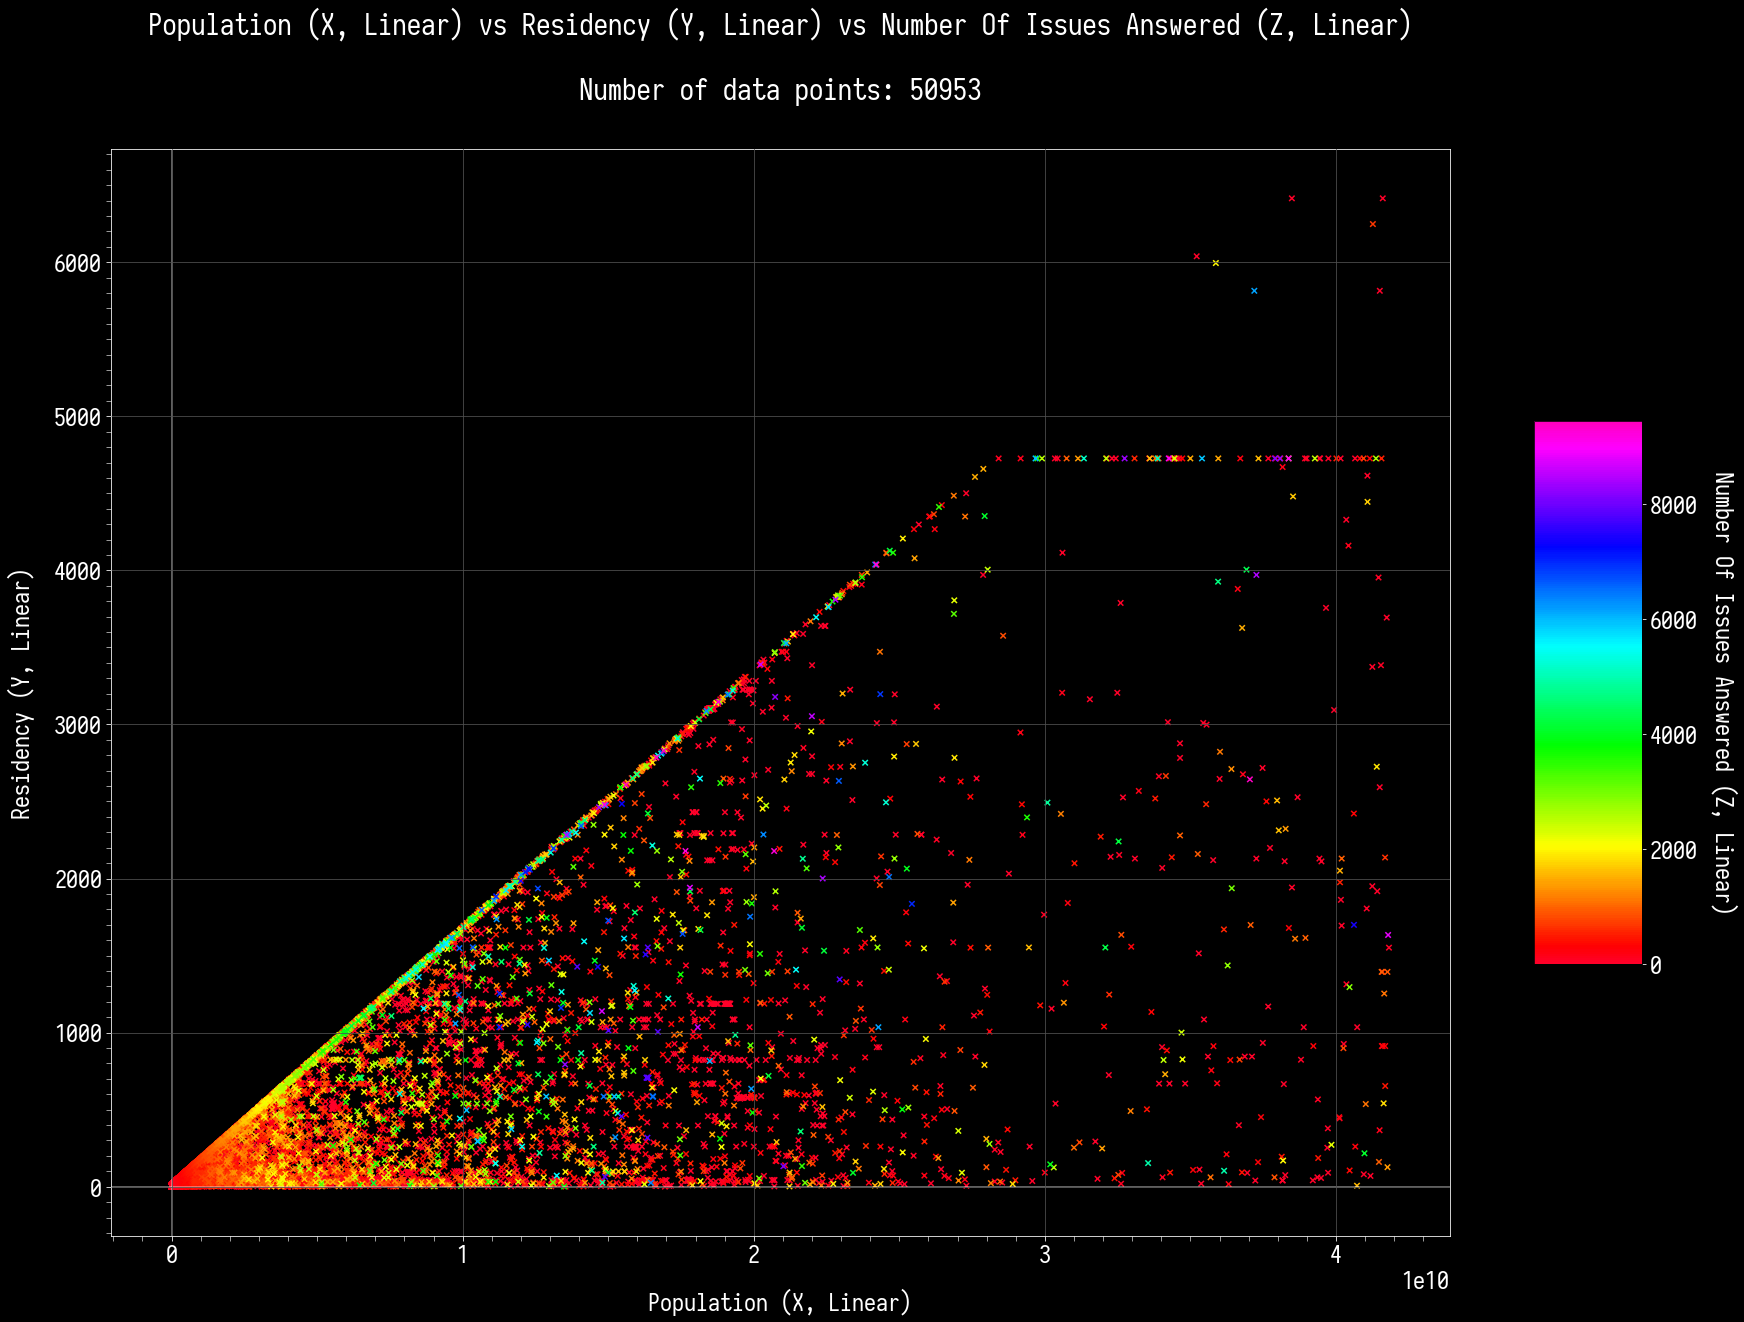

In [24]:
print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())
print("Min Z:", Z.min(),"// Max Y:", Z.max())

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Y_lab = YLin
Z_lab = ZLin

linthreshx = 10**1
linthreshy = 10**0
linthreshz = 10**1

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(30, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    ax.set_xscale("linear")
else:
#     ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    ax.set_xscale("log", base = 10)
    
if Y_lab == YLin:
    ax.set_yscale("linear")
else:
#     ax.set_yscale("symlog", base = 10, linthresh = linthreshy)
    ax.set_yscale("log", base = 10)

cmap = plt.get_cmap('gist_rainbow')
cmap = truncate_colormap(cmap, 0.0, 1.0)
ax.set_facecolor("black")
ax.set_title(X_lab + " vs " + Y_lab + " vs " + Z_lab +"\n\n" + "Number of data points: " + str(len(df2)), pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)
    
if Z_lab == ZLin:
    data = ax.scatter(X, Y, c = Z, cmap = cmap, vmin = Z.min(), vmax = Z.max(), marker = "x", s = 30)
else:
    data = ax.scatter(X, Y, c = Z, cmap = cmap, marker = "x", s = 30, norm = colors.SymLogNorm(vmin = Z.min(), vmax = Z.max(), base = 10, linthresh = linthreshz))

cbar = fig.colorbar(data, shrink = 0.5, aspect = 5)
cbar.set_label(Z_lab, labelpad = 40, rotation = 270, color = "white")
cbar.ax.tick_params(color = "white", labelcolor = "white")

# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Set limits on graphs.
# ax.set_xlim(xmin = 0, xmax = 500)
# ax.set_ylim(ymin = 10**-2, ymax = 10**3)

# Inverts y-axis.
# plt.gca().invert_yaxis()
    
# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# ----- Regression thing. poly1d_fn is now a function which takes in x and returns an estimate for y

n = 1
coef = np.polyfit(X, Y, n)
np.set_printoptions(precision = 4)
print("Coefficients:", coef)
poly = np.poly1d(coef)
sortedpoly = np.sort(X)

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])

np.random.seed(0)

# transforming the data to include another axis
X2 = X[:, np.newaxis]
Y2 = Y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree = n)
x_poly = polynomial_features.fit_transform(X2)

model = LinearRegression()
model.fit(x_poly, Y2)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(Y2, y_poly_pred))
r2 = r2_score(Y2, y_poly_pred)
print(rmse)
print(r2)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X2, y_poly_pred), key=sort_axis)
X2, y_poly_pred = zip(*sorted_zip)

# Regression Plot.
# ax.plot(X2, y_poly_pred, color = 'w')

# Y = X line for scaling reference. Mostly useful for symmlogs.
# ax.plot(X2, Y2, color = (64/255, 192/255, 255/255))

print(ordinal(n),"order polynomial. The Root-Mean Square Error is",'{:,.6g}'.format(rmse)+", the R-Squared Score is", '{:,.6g}'.format(r2) +", both accurate to 6 significant figures.")

In [25]:
# SKIP THIS CHUNK OF CODE IF YOU ARE NOT INTENT ON RUNNING DENSITY. THIS TAKES VERY LONG.

start_time = time.time()

# Calculate the point density. Credit: Joe Kington: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
xy = np.vstack([X, Y])
Freq_XY = gaussian_kde(xy)(xy)

print("Time taken:", time.time() - start_time)

Time taken: 36.59640145301819


Min X: 5000000.0 // Max X: 41820000000.0
Min Y: 0.00647916252 // Max Y: 6414.70422792
Coefficients: [7.5240e-08 3.7564e+01]
294.44703740509755
0.5739271928865606


C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12804/3429072480.py:107: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X2 = X[:, np.newaxis]
C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_12804/3429072480.py:108: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y2 = Y[:, np.newaxis]


1st order polynomial. The Root-Mean Square Error is 294.447, the R-Squared Score is 0.573927, both accurate to 6 significant figures.


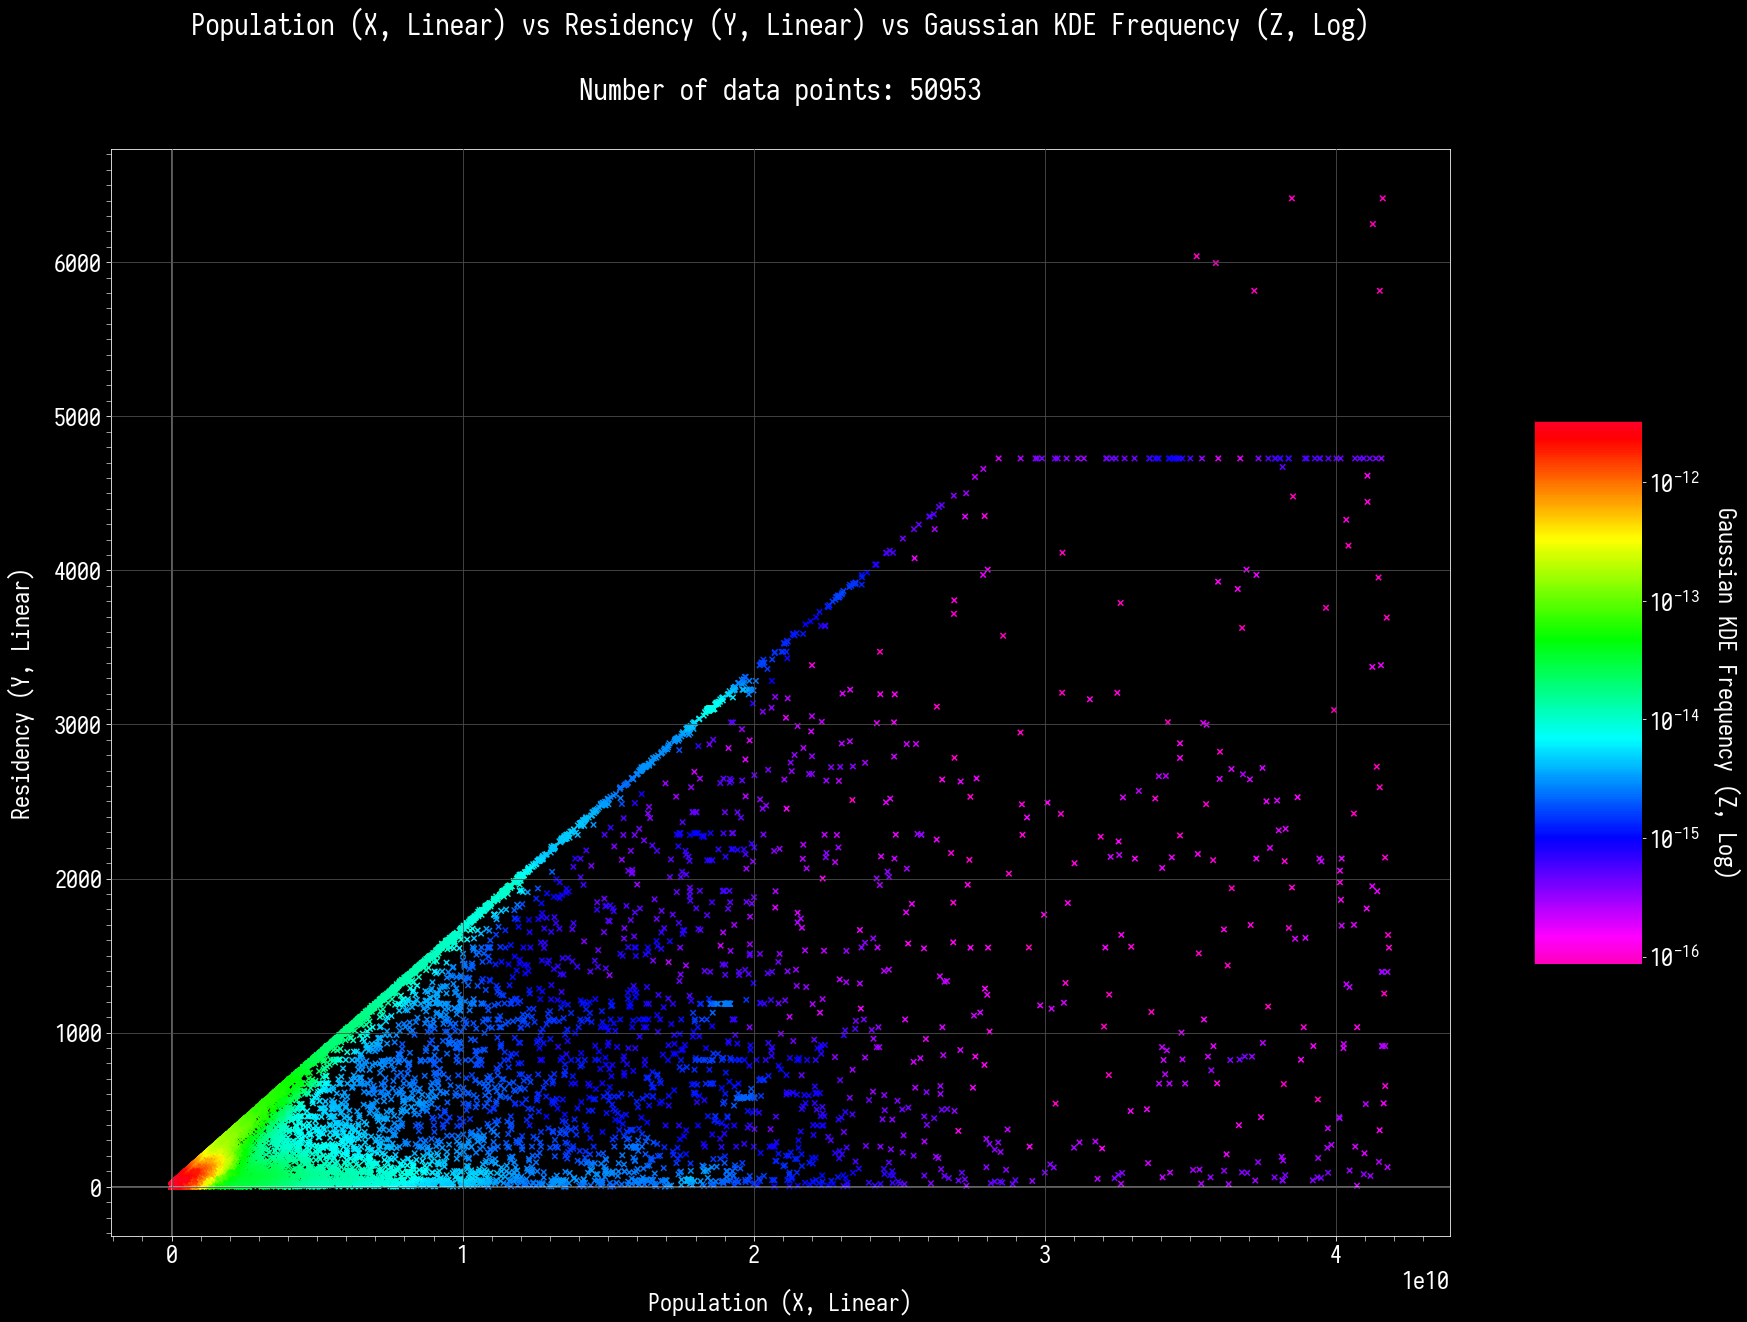

In [26]:
# Gaussian Frequency for Z-axis / Colormap. By default, Red: Most clustered, Pink: Least clustered.

print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())

FreqLin = "Gaussian KDE Frequency (Z, Linear)"
FreqLog = "Gaussian KDE Frequency (Z, Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Y_lab = YLin
Freq_lab = FreqLog # Best to keep it at log for the time being. The density function has very differing OOM (Order of Magnitude).

linthreshx = 10**0
linthreshy = 10**0
linthreshz = Freq_XY.min()
# linthreshz = 10

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(30, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    ax.set_xscale("linear")
else:
#     ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    ax.set_xscale("log", base = 10)
    
if Y_lab == YLin:
    ax.set_yscale("linear")
else:
#     ax.set_yscale("symlog", base = 10, linthresh = linthreshy)
    ax.set_yscale("log", base = 10)

cmap = plt.get_cmap('gist_rainbow_r')
cmap = truncate_colormap(cmap, 0, 1)

ax.set_facecolor("black")
ax.set_title(X_lab + " vs " + Y_lab + " vs " + Freq_lab +"\n\n" + "Number of data points: " + str(len(df2)), pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)
    
if Freq_lab == FreqLin:
    data = ax.scatter(X, Y, c = Freq_XY, cmap = cmap, vmin = Freq_XY.min(), vmax = Freq_XY.max(), marker = "x", s = 30)
else:
    data = ax.scatter(X, Y, c = Freq_XY, cmap = cmap, marker = "x", s = 30, norm = colors.SymLogNorm(vmin = Freq_XY.min(), vmax = Freq_XY.max(), linthresh = linthreshz))

cbar = fig.colorbar(data, shrink = 0.5, aspect = 5)
cbar.set_label(Freq_lab, labelpad = 40, rotation = 270, color = "white")
cbar.ax.tick_params(color = "white", labelcolor = "white")

# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 0, xmax = 25000)
# ax.set_ylim(ymin = -0.25, ymax = 0.25)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

# ----- Regression thing. poly1d_fn is now a function which takes in x and returns an estimate for y

n = 1
coef = np.polyfit(X, Y, n)
np.set_printoptions(precision = 4)
print("Coefficients:", coef)
poly = np.poly1d(coef)
sortedpoly = np.sort(X)

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])

np.random.seed(0)

# transforming the data to include another axis
X2 = X[:, np.newaxis]
Y2 = Y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree = n)
x_poly = polynomial_features.fit_transform(X2)

model = LinearRegression()
model.fit(x_poly, Y2)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(Y2, y_poly_pred))
r2 = r2_score(Y2, y_poly_pred)
print(rmse)
print(r2)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X2, y_poly_pred), key=sort_axis)
X2, y_poly_pred = zip(*sorted_zip)

# Regression Plot.
# ax.plot(X2, y_poly_pred, color = 'w')

# Y = X line for scaling reference. Mostly useful for symmlogs.
# ax.plot(X2, X2, color = (64/255, 192/255, 255/255))

print(ordinal(n),"order polynomial. The Root-Mean Square Error is",'{:,.6g}'.format(rmse)+", the R-Squared Score is", '{:,.6g}'.format(r2) +", both accurate to 6 significant figures.")

In [27]:
bottom_value_x = (X.sort_values(ascending = False).reset_index(drop = True))[int(len(X) * 0.90)]
top_value_x = (X.sort_values(ascending = False).reset_index(drop = True))[int(len(X) * 0.10)]

bottom_value_y = (Y.sort_values(ascending = False).reset_index(drop = True))[int(len(Y) * 0.90)]
top_value_y = (Y.sort_values(ascending = False).reset_index(drop = True))[int(len(Y) * 0.10)]

bottom_value_z = (Z.sort_values(ascending = False).reset_index(drop = True))[int(len(Z) * 0.90)]
top_value_z = (Z.sort_values(ascending = False).reset_index(drop = True))[int(len(Z) * 0.10)]

# Switch to this for issues answered.
bottom_value_issues = 100
top_value_issues = 1000

x_value = x + " (x)"
y_value = y + " (y)"
z_value = z + " (z)"

Filter1 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] > top_value_y)] # Top for both. Value.
Filter2 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] < bottom_value_y)] # Bottom for both. Value.
Filter3 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] < top_value_y)] # Top x, Bottom y. Value.
Filter4 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] > bottom_value_y)] # Bottom x, Top y. Value.

print("X max and Y max:", len(df2[(X == X.max()) & (Y == Y.max())]))
print("X min and Y min:", len(df2[(X == X.min()) & (Y == Y.min())]))
print("X max and Y min:", len(df2[(X == X.max()) & (Y == Y.min())]))
print("X min and Y max:", len(df2[(X == X.min()) & (Y == Y.max())]))
print("\n")
print("X max:", len(df2[(X == X.max())]))
print("X min:", len(df2[(X == X.min())]))
print("Y max:", len(df2[(Y == Y.max())]))
print("Y min:", len(df2[(Y == Y.min())]))
print("Z max:", len(df2[(Z == Z.max())]))
print("Z min:", len(df2[(Z == Z.min())]))
print("\n")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"):",len(Filter1), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"):",len(Filter2), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"):",len(Filter3), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"):",len(Filter4), "nations out of",str(len(df2))+".")

Filter5 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] > top_value_y) & (df2[z_value] > top_value_z)] # Hi X, Hi Y, Hi Z
Filter6 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] > top_value_y) & (df2[z_value] < bottom_value_z)] # Hi X, Hi Y, Lo Z
Filter7 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] < bottom_value_y) & (df2[z_value] > top_value_z)] # Lo X, Lo Y, Hi Z
Filter8 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] < bottom_value_y) & (df2[z_value] < bottom_value_z)] # Lo X, Lo Y, Lo Z
Filter9 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] < bottom_value_y) & (df2[z_value] > top_value_z)] # Hi X, Lo Y, Hi Z
Filter10 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] < bottom_value_y) & (df2[z_value] < bottom_value_z)] # Hi X, Lo Y, Lo Z
Filter11 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] > top_value_y) & (df2[z_value] > top_value_z)] # Lo X, Hi Y, Hi Z
Filter12 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] > top_value_y) & (df2[z_value] < bottom_value_z)] # Lo X, Hi Y, Lo Z
    
print("\n")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), High",string.capwords(z),"(>",str('{:,.2f}'.format(top_value_z))+"):",len(Filter5), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), Low",string.capwords(z),"(<",str('{:,.2f}'.format(bottom_value_z))+"):",len(Filter6), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), High",string.capwords(z),"(>",str('{:,.2f}'.format(top_value_z))+"):",len(Filter7), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), Low",string.capwords(z),"(<",str('{:,.2f}'.format(bottom_value_z))+"):",len(Filter8), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), High",string.capwords(z),"(>",str('{:,.2f}'.format(top_value_z))+"):",len(Filter9), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), Low",string.capwords(z),"(<",str('{:,.2f}'.format(bottom_value_z))+"):",len(Filter10), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), High",string.capwords(z),"(>",str('{:,.2f}'.format(top_value_z))+"):",len(Filter11), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), Low",string.capwords(z),"(<",str('{:,.2f}'.format(bottom_value_z))+"):",len(Filter12), "nations out of",str(len(df2))+".")

Filter13 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] > top_value_y) & (df2["Number of Issues Answered"] > top_value_issues)] # Hi X, Hi Y, Hi Z
Filter14 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] > top_value_y) & (df2["Number of Issues Answered"] < bottom_value_issues)] # Hi X, Hi Y, Lo Z
Filter15 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] < bottom_value_y) & (df2["Number of Issues Answered"] > top_value_issues)] # Lo X, Lo Y, Hi Z
Filter16 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] < bottom_value_y) & (df2["Number of Issues Answered"] < bottom_value_issues)] # Lo X, Lo Y, Lo Z
Filter17 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] < bottom_value_y) & (df2["Number of Issues Answered"] > top_value_issues)] # Hi X, Lo Y, Hi Z
Filter18 =  df2[(df2[x_value] > top_value_x) & (df2[y_value] < bottom_value_y) & (df2["Number of Issues Answered"] < bottom_value_issues)] # Hi X, Lo Y, Lo Z
Filter19 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] > top_value_y) & (df2["Number of Issues Answered"] > top_value_issues)] # Lo X, Hi Y, Hi Z
Filter20 =  df2[(df2[x_value] < bottom_value_x) & (df2[y_value] > top_value_y) & (df2["Number of Issues Answered"] < bottom_value_issues)] # Lo X, Hi Y, Lo Z

print("\n")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), High",string.capwords("Number of Issues Answered"),"(>",str('{:,.0f}'.format(top_value_issues))+"):",len(Filter13), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), Low",string.capwords("Number of Issues Answered"),"(<",str('{:,.0f}'.format(bottom_value_issues))+"):",len(Filter14), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), High",string.capwords("Number of Issues Answered"),"(>",str('{:,.0f}'.format(top_value_issues))+"):",len(Filter15), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), Low",string.capwords("Number of Issues Answered"),"(<",str('{:,.0f}'.format(bottom_value_issues))+"):",len(Filter16), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), High",string.capwords("Number of Issues Answered"),"(>",str('{:,.0f}'.format(top_value_issues))+"):",len(Filter17), "nations out of",str(len(df2))+".")
print("High",string.capwords(x),"(>",str('{:,.2f}'.format(top_value_x))+"), Low",string.capwords(y),"(<",str('{:,.2f}'.format(bottom_value_y))+"), Low",string.capwords("Number of Issues Answered"),"(<",str('{:,.0f}'.format(bottom_value_issues))+"):",len(Filter18), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), High",string.capwords("Number of Issues Answered"),"(>",str('{:,.0f}'.format(top_value_issues))+"):",len(Filter19), "nations out of",str(len(df2))+".")
print("Low",string.capwords(x),"(<",str('{:,.2f}'.format(bottom_value_x))+"), High",string.capwords(y),"(>",str('{:,.2f}'.format(top_value_y))+"), Low",string.capwords("Number of Issues Answered"),"(<",str('{:,.0f}'.format(bottom_value_issues))+"):",len(Filter20), "nations out of",str(len(df2))+".")

X max and Y max: 0
X min and Y min: 0
X max and Y min: 0
X min and Y max: 0


X max: 1
X min: 82
Y max: 2
Y min: 1
Z max: 1
Z min: 13252


High Population (> 4,387,000,000.00), High Residency (> 391.51): 3549 nations out of 50953.
Low Population (< 12,000,000.00), Low Residency (< 5.72): 4653 nations out of 50953.
High Population (> 4,387,000,000.00), Low Residency (< 5.72): 1546 nations out of 50953.
Low Population (< 12,000,000.00), High Residency (> 391.51): 17 nations out of 50953.


High Population (> 4,387,000,000.00), High Residency (> 391.51), High Number Of Issues Answered (> 348.00): 1844 nations out of 50953.
High Population (> 4,387,000,000.00), High Residency (> 391.51), Low Number Of Issues Answered (< 0.00): 0 nations out of 50953.
Low Population (< 12,000,000.00), Low Residency (< 5.72), High Number Of Issues Answered (> 348.00): 0 nations out of 50953.
Low Population (< 12,000,000.00), Low Residency (< 5.72), Low Number Of Issues Answered (< 0.00): 0 nations out of 509

In [36]:
df2[(X == X.max()) | (X == X.min())].style.format({              
                
     df2.columns[2] : '{:,.0f}', 

     df2.columns[4] : '{:,.0f}',
     df2.columns[6] : '{:,.3f}', 
     df2.columns[7] : '{:,.3f}', 
     df2.columns[8] : '{:,.3f}', })

# df2[(Y == Y.min()) | (Y == Y.max())].style.format({              
                
#      df2.columns[2] : '{:,.0f}', 

#      df2.columns[4] : '{:,.0f}',
#      df2.columns[6] : '{:,.3f}', 
#      df2.columns[7] : '{:,.3f}', 
#      df2.columns[8] : '{:,.3f}', })

,Short Name of the Nation (no pretitle),Region,Population of Nation,Category,Number of Issues Answered,Time of Extraction,population (x),residency (y),Number of Issues Answered (z)
674,malicious_observations,The North Pacific,"5,000,000",Inoffensive Centrist Democracy,0,2022-01-30 23:20:16,"5,000,000.000",0.635,0.000
685,timladned,The North Pacific,"5,000,000",New York Times Democracy,0,2022-01-30 23:20:11,"5,000,000.000",0.656,0.000
695,tinrae,The North Pacific,"5,000,000",Civil Rights Lovefest,0,2022-01-30 23:19:59,"5,000,000.000",0.754,0.000
696,f_r_a,The North Pacific,"5,000,000",Corporate Bordello,0,2022-01-30 23:20:02,"5,000,000.000",0.741,0.000
697,free_republic_of_antartica,The North Pacific,"5,000,000",Inoffensive Centrist Democracy,0,2022-01-30 23:20:04,"5,000,000.000",0.737,0.000
698,i_did_war_crimes_in_brasil,The North Pacific,"5,000,000",Corporate Police State,0,2022-01-30 23:20:06,"5,000,000.000",0.728,0.000
699,wead_kiust,The North Pacific,"5,000,000",Democratic Socialists,0,2022-01-30 23:20:07,"5,000,000.000",0.687,0.000
700,timayat,The North Pacific,"5,000,000",New York Times Democracy,0,2022-01-30 23:20:08,"5,000,000.000",0.678,0.000
2465,nyurburg,the Pacific,"5,000,000",Liberal Democratic Socialists,0,2022-01-30 14:58:44,"5,000,000.000",0.588,0.000
2466,olleistan,the Pacific,"5,000,000",Inoffensive Centrist Democracy,0,2022-01-30 14:58:43,"5,000,000.000",0.589,0.000


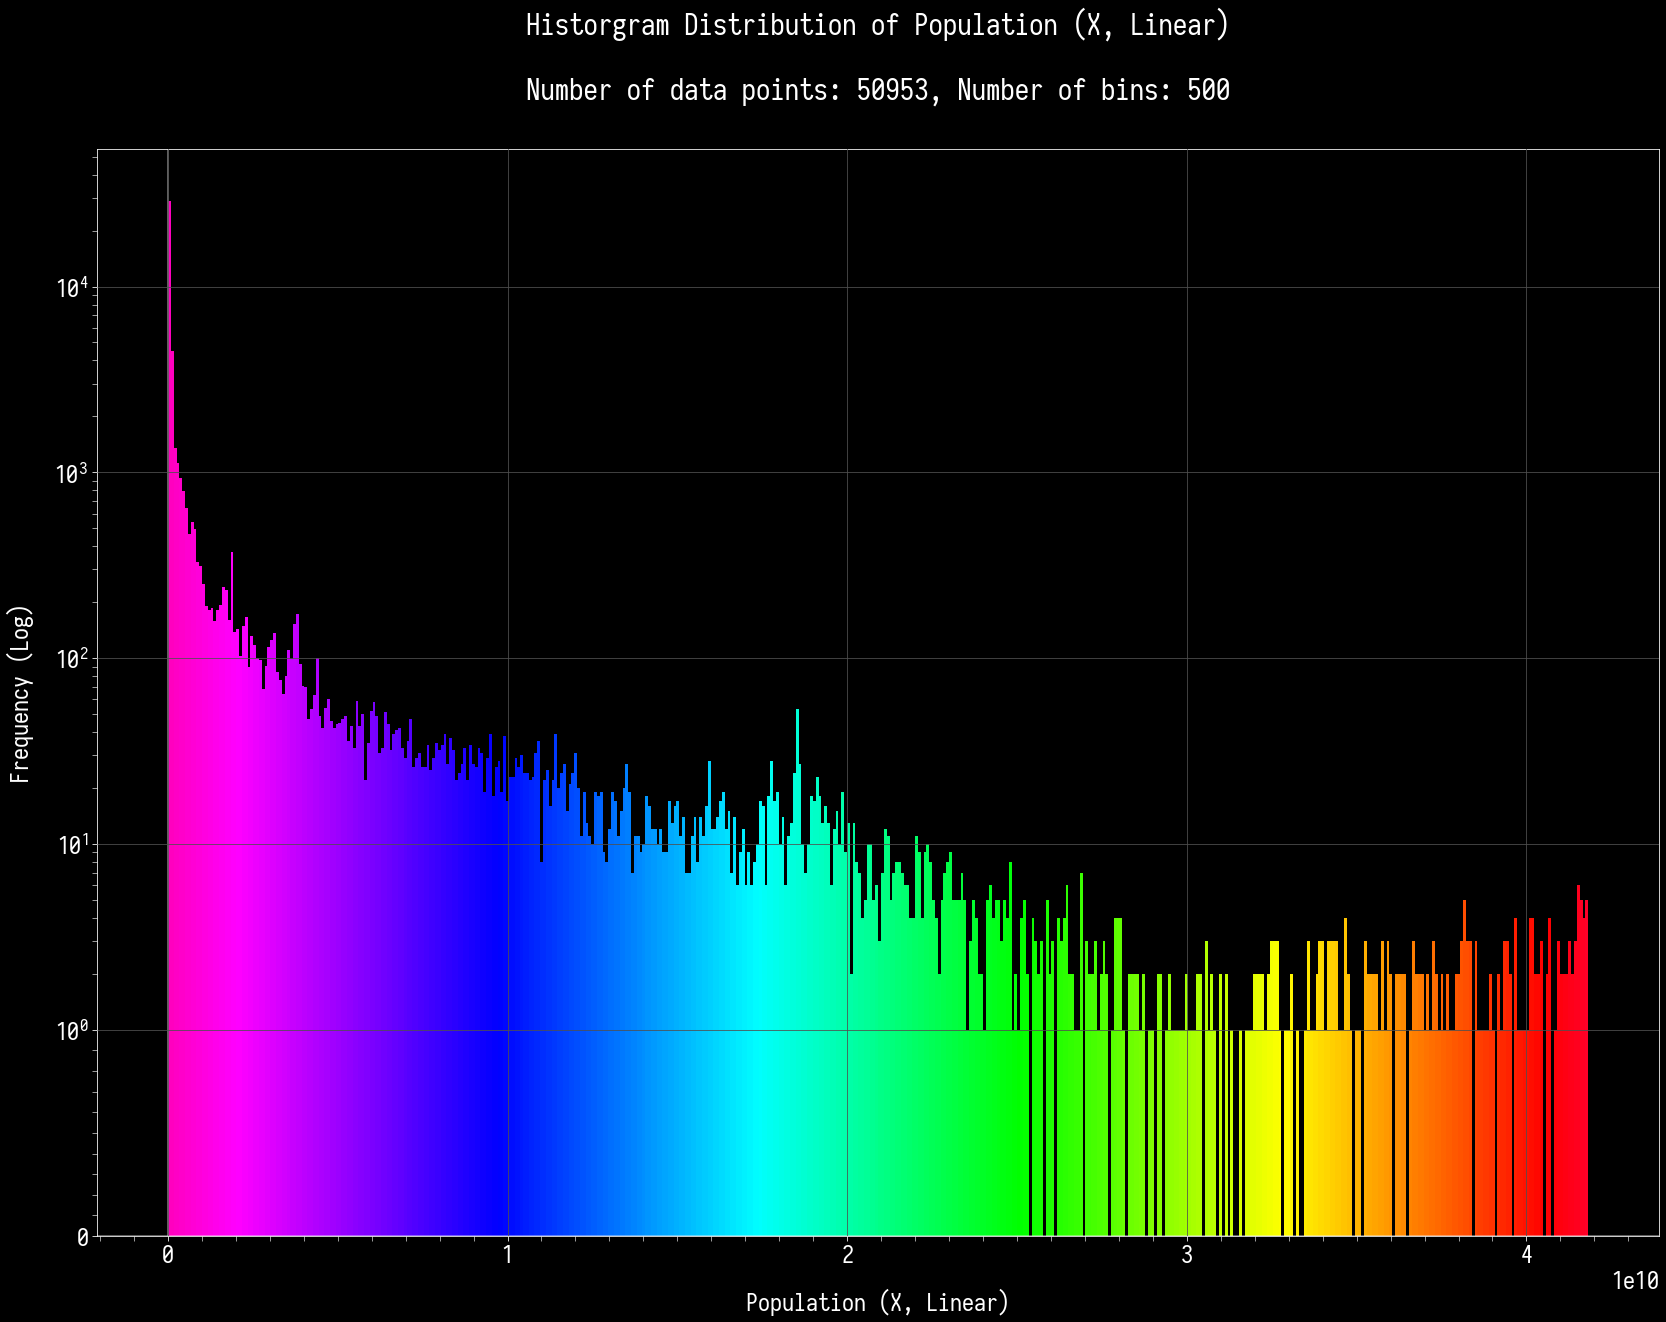

In [29]:
# Histogram for individual data - X-axis.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(28, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

HistFreqLin = "Frequency (Linear)"
HistFreqLog = "Frequency (Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Hist_Freq_lab = HistFreqLog

linthreshx = 1
linthresh_hist = 1

Num_Bins = 500

if X_lab == XLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    
if Hist_Freq_lab == HistFreqLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthresh_hist)

ax.set_facecolor("black")
ax.set_title("Historgram Distribution of " + X_lab + "\n\n" + "Number of data points: " + str(len(df2)) + ", Number of bins: " + str(Num_Bins), pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Hist_Freq_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# --------------------------------------------------------
# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Hist_Freq_lab == HistFreqLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthresh_hist))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 50, xmax = 70)
# ax.set_ylim(ymin = 0, ymax = 3500)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

cm = plt.cm.gist_rainbow_r

n, bins, patches = plt.hist(X, Num_Bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/Num_Bins))

plt.show()

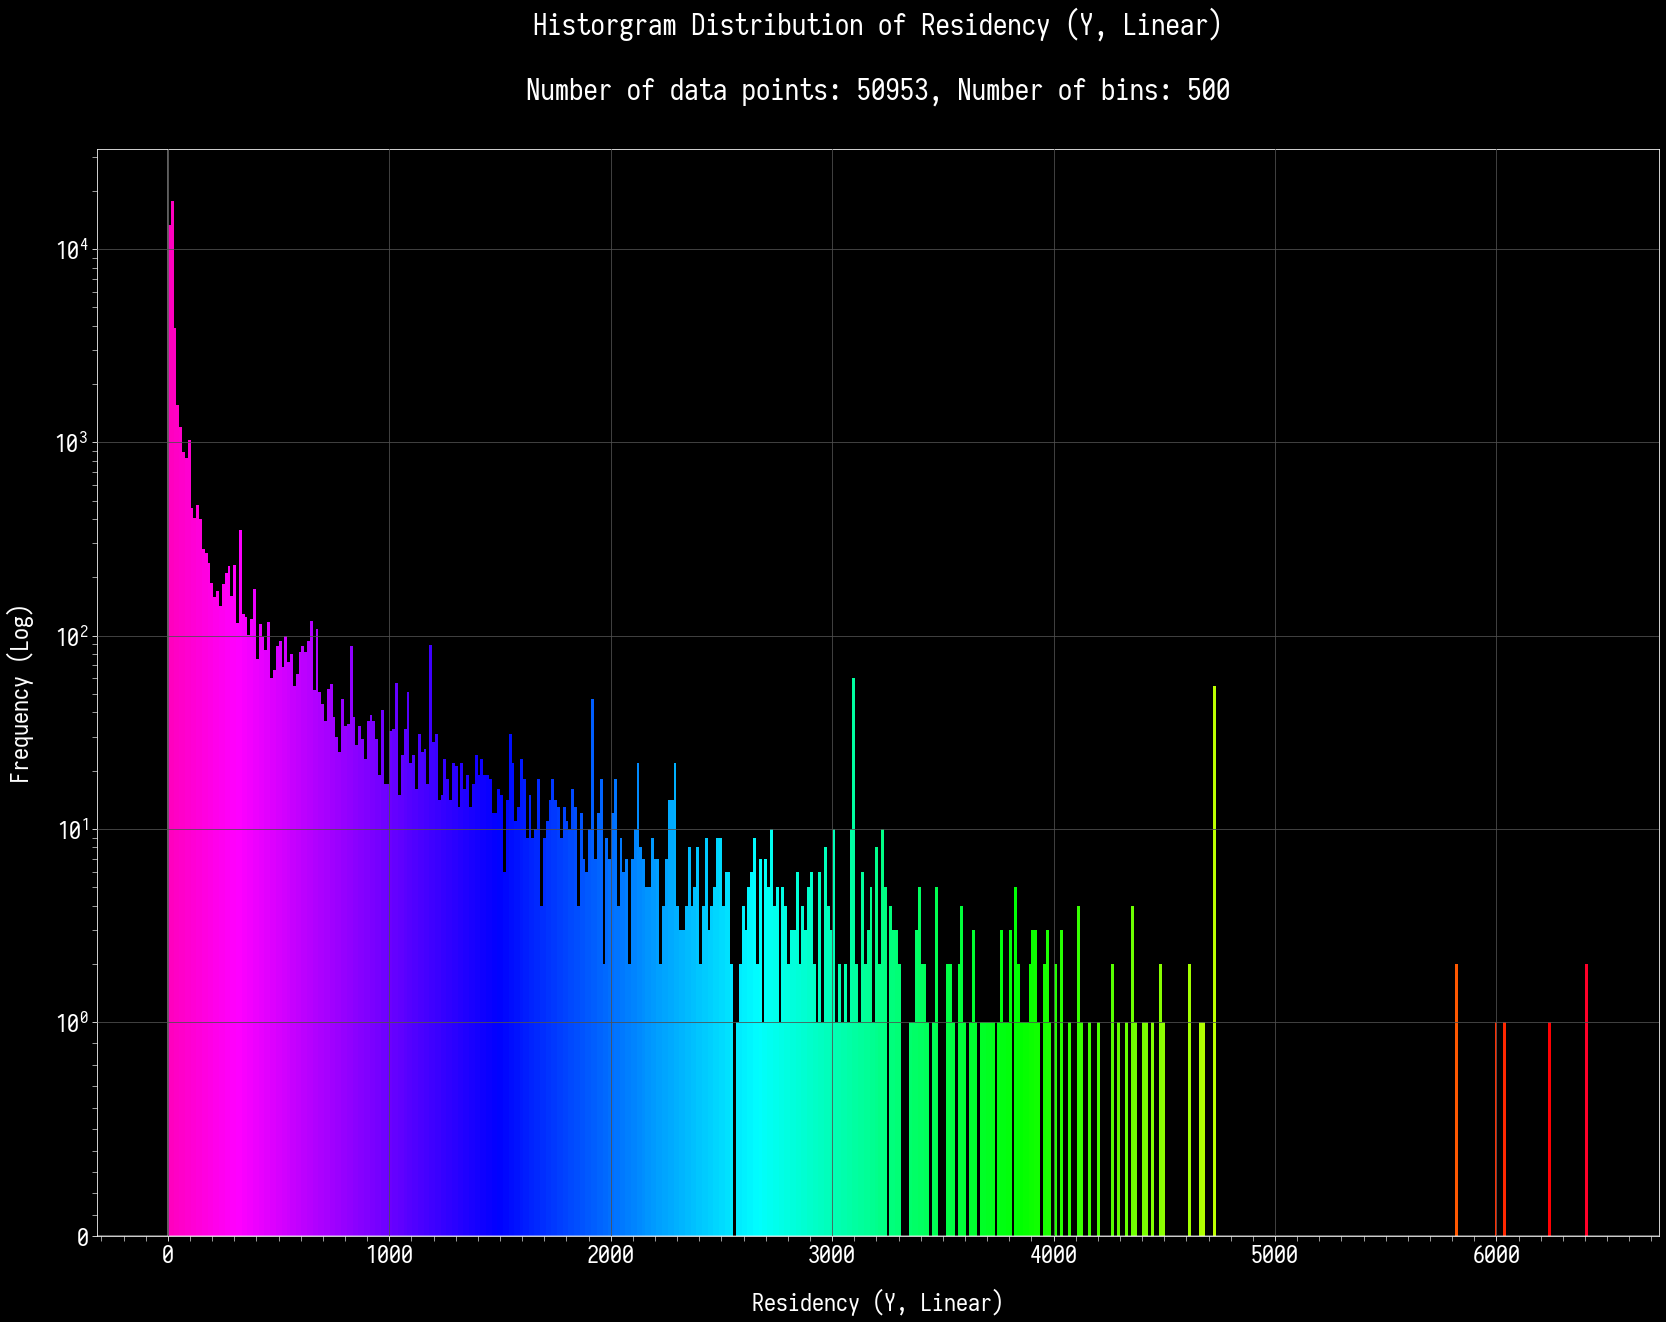

In [30]:
# Histogram for individual data - Y-axis.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(28, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

HistFreqLin = "Frequency (Linear)"
HistFreqLog = "Frequency (Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
Y_lab = YLin
Hist_Freq_lab = HistFreqLog

linthreshy = 1
linthresh_hist = 1

Num_Bins = 500

if Y_lab == YLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshy)
    
if Hist_Freq_lab == HistFreqLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthresh_hist)

ax.set_facecolor("black")
title = ax.set_title("Historgram Distribution of " + Y_lab + "\n\n" + "Number of data points: " + str(len(df2)) + ", Number of bins: " + str(Num_Bins), pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(Y_lab, color = "white", labelpad = 20)
ax.set_ylabel(Hist_Freq_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# --------------------------------------------------------
# Providing minor tick marks for both symlog and linear.
if Y_lab == YLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Hist_Freq_lab == HistFreqLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthresh_hist))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 55, xmax = 65)
# ax.set_ylim(ymin = 0, ymax = 2000)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

cm = plt.cm.gist_rainbow_r

n, bins, patches = plt.hist(Y, Num_Bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/Num_Bins))

plt.show()

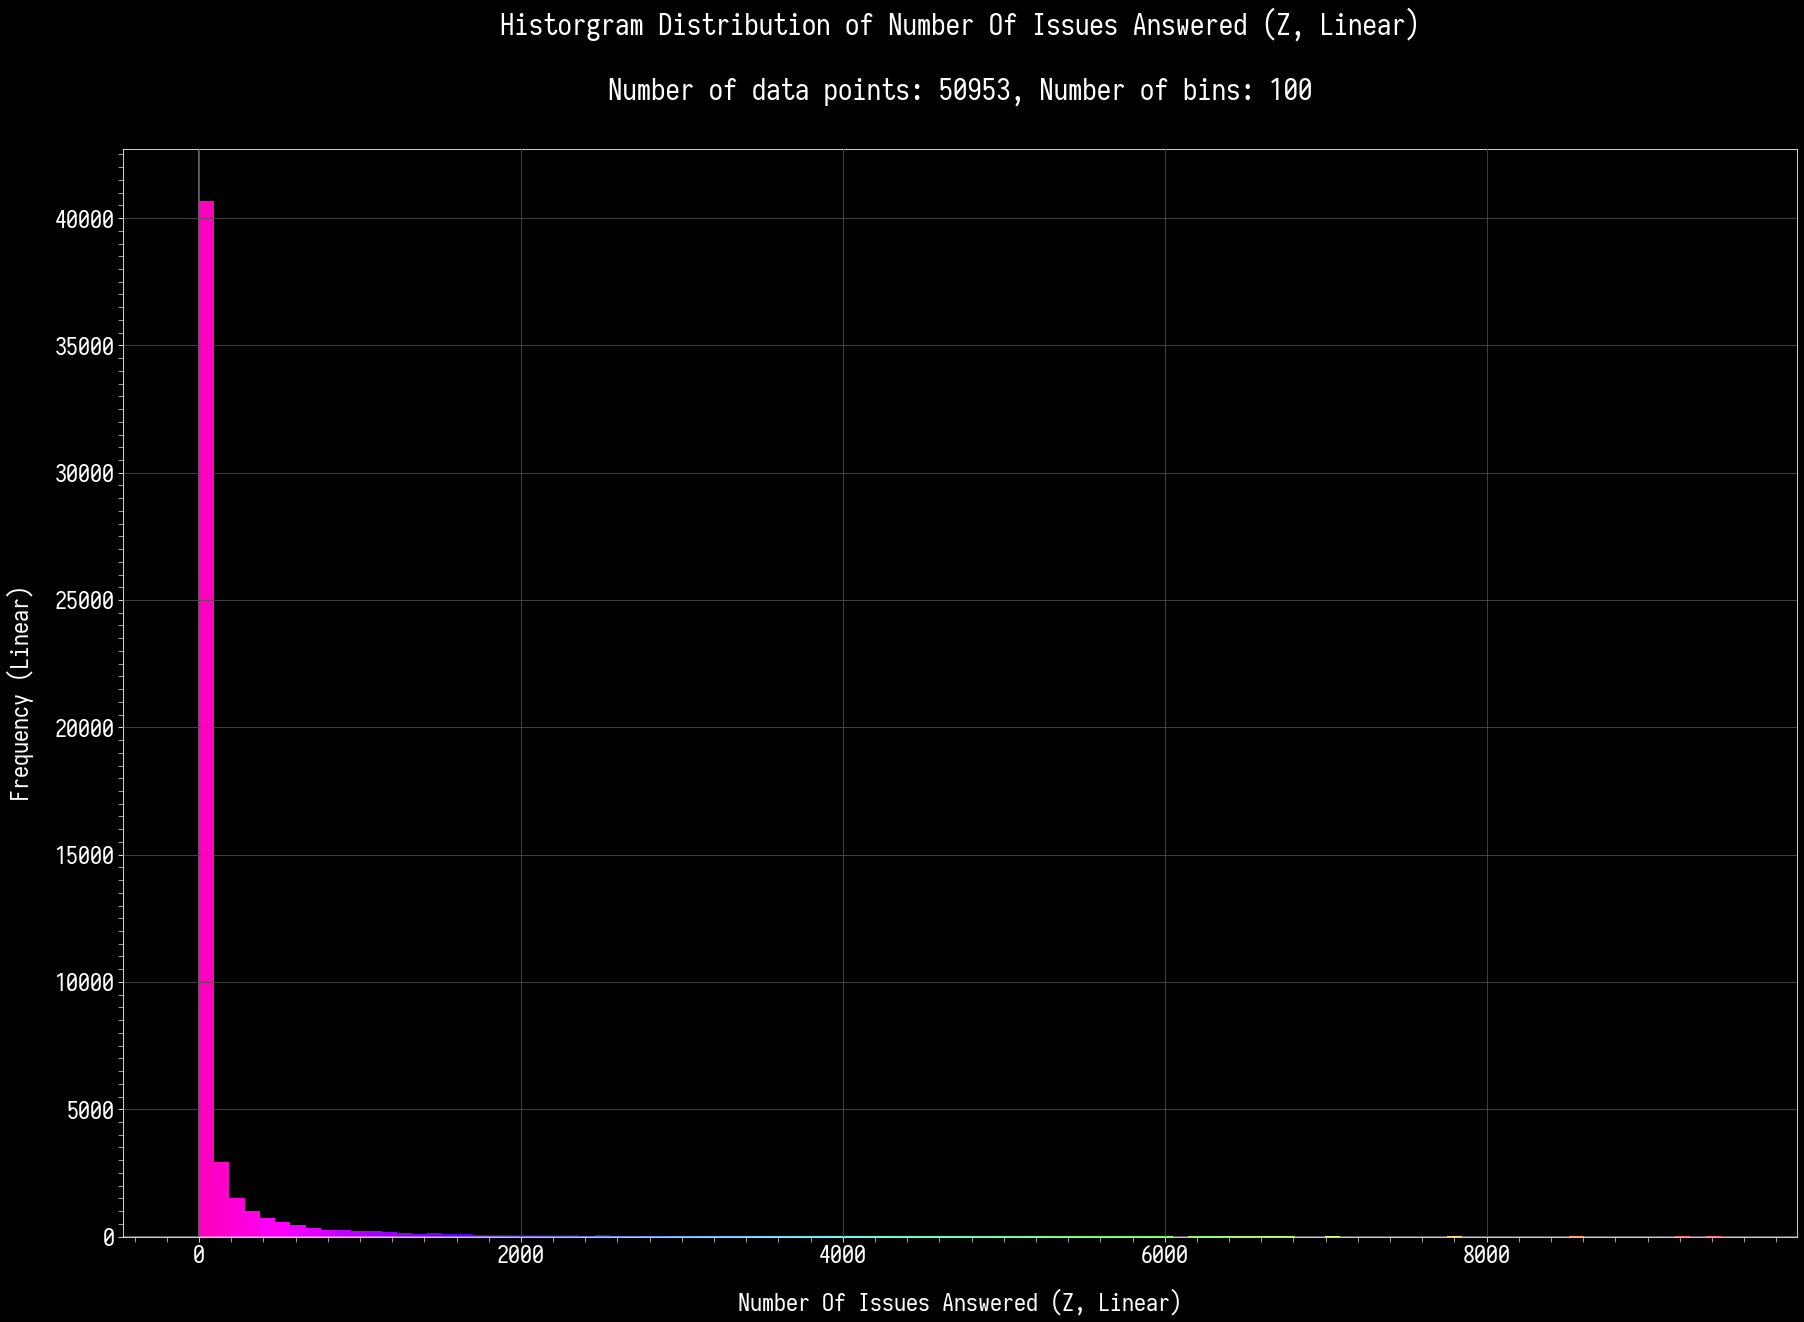

In [31]:
# Histogram for individual data - Z-axis.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(30, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

HistFreqLin = "Frequency (Linear)"
HistFreqLog = "Frequency (Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
Z_lab = ZLin
Hist_Freq_lab = HistFreqLin

linthreshz = 1
linthresh_hist = 0.01

Num_Bins = 100

single_out = False

if Z_lab == ZLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshz)
    
if Hist_Freq_lab == HistFreqLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthresh_hist)

ax.set_facecolor("black")
title = ax.set_title("Historgram Distribution of " + Z_lab + "\n\n" + "Number of data points: " + str(len(df2)) + ", Number of bins: " + str(Num_Bins), pad = 50, color ="white")
ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(Z_lab, color = "white", labelpad = 20)
ax.set_ylabel(Hist_Freq_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# --------------------------------------------------------
# Providing minor tick marks for both symlog and linear.
if Z_lab == ZLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshz))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Hist_Freq_lab == HistFreqLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthresh_hist))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 0, xmax = 25000)
# ax.set_ylim(ymin = -0.25, ymax = 0.25)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

cm = plt.cm.gist_rainbow_r

n, bins, patches = plt.hist(Z, Num_Bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/Num_Bins))

plt.show()

In [32]:
# By Category.

import string

Category_Group = df1[(df1["Category"] == "Father Knows Best State") | (df1["Category"] == "Mother Knows Best State")]
Category_Group = Category_Group.groupby(['Category']).sum()
Category_Group["Category"] = Category_Group.index
Category_Group["Deck Value Average"] = Category_Group["deck value"] / Category_Group["Nation Count"]

Category_Group["Category by %"] = Category_Group["Nation Count"] / len(df1) * 100

Category_Group = Category_Group.reset_index(drop=True)
Category_Group.index = Category_Group.index + 1

# Make data.
x2 = 'civil rights'
# y_idx = "Region Index"
y2 = 'political freedoms'
z2 = 'economic freedom'

xrank = x2 + " rank"
yrank = y2 + " rank"
zrank = z2 + " rank"

X2 = Category_Group[x2]
# Y_idx = df1[y_idx]
Y2 = Category_Group[y2]
Z2 = Category_Group[z2]

deg = 1

# np.polyfit(X, Y, deg = deg)

df_cat = pd.DataFrame({
    "Category": Category_Group["Category"],
    # "Combined Population of Category": Category_Group["population"],
    "Nation Count": Category_Group["Nation Count"],
    "Category by %": Category_Group["Category by %"],
    
    x2 + " (x)" : X2 / Category_Group["Nation Count"],
    # xrank: df1[xrank],
    
    # y_idx : Y_idx,
     
    y2 + " (y)" : Y2 / Category_Group["Nation Count"],
    # yrank: df1[yrank],
    
    z2 + " (z)" : Z2 / Category_Group["Nation Count"],
    
    # zrank: df1[zrank],

    
                   })

# Sort and filter / cut off

df_cat.sort_values(by = df_cat.columns[1], inplace = True, ascending = False)
df_cat = df_cat.reset_index(drop=True)
df_cat.index = df_cat.index + 1

# df2 = df2[(df2["Category"].str.contains("Corporate Police State"))]
                                                      
print(len(df_cat))

pd.concat([df_cat.head(50)]).style.format({
                df_cat.columns[1] : '{:,.0f}', 
                df_cat.columns[2] : '{:,.3f}', 
                
                df_cat.columns[3] : '{:,.3f}', 
                df_cat.columns[4] : '{:,.3f}', 
                df_cat.columns[5] : '{:,.3f}', 


                })

2


,Category,Nation Count,Category by %,civil rights (x),political freedoms (y),economic freedom (z)
1,Father Knows Best State,"2,387",4.685,51.925,18.249,41.242
2,Mother Knows Best State,65,0.128,51.204,16.493,31.639


In [33]:
# Multivariable Regression Thingy.

from sklearn import linear_model
pd.set_option('display.max_rows', 100)

df_reg_x = df1[industry_list]
df_reg_y = df1["lifespan"]

df_reg_x_norm = (df1[industry_list] - df1[industry_list].min()) / (df1[industry_list].max() - df1[industry_list].min())
df_reg_y_norm = (df1["lifespan"] - df1["lifespan"].min()) / (df1["lifespan"].max() - df1["lifespan"].min())

regr = linear_model.LinearRegression()
regr.fit(df_reg_x, df_reg_y)
print(regr.coef_)

regr_norm = linear_model.LinearRegression()
regr_norm.fit(df_reg_x_norm, df_reg_y_norm)
print(regr_norm.coef_)

df_effect = pd.DataFrame(np.array(regr.coef_).reshape(-1, len(regr.coef_)), columns = industry_list).T
df_effect_norm = pd.DataFrame(np.array(regr_norm.coef_).reshape(-1, len(regr_norm.coef_)), columns = industry_list).T
df_effect_combined = pd.concat([df_effect, df_effect_norm], axis=1)
df_effect_combined.columns=["Effect on Lifespan", "Effect on Lifespan (Normalized)"]

df_effect_combined.sort_index()

[ 5.0566e-02  1.5985e-04  5.0610e-02  1.5145e-04 -2.8950e-04  6.5964e-05
  5.0455e-02  1.4983e-04 -7.0641e-04  9.8762e-05 -1.1460e-04  1.9381e-04
  9.6289e-05 -2.2494e-04  1.7011e-04 -2.6223e-04 -5.0517e-02  1.3543e-02]
[ 5.3677e+01  6.6446e-02  3.9314e+01  4.9878e-01 -2.7705e-01  5.5565e-02
  1.2631e+02  2.0730e-01 -7.3049e-01  1.1151e-01 -1.7727e-01  1.2967e-01
  5.2997e-02 -2.8936e-01  2.5102e-01 -2.5201e-01 -1.3833e+02  7.6928e-01]


,Effect on Lifespan,Effect on Lifespan (Normalized)
industry: arms manufacturing,0.050455,126.312039
industry: automobile manufacturing,0.050566,53.676590
industry: basket weaving,0.050610,39.314002
industry: beverage sales,-0.000706,-0.730491
industry: book publishing,0.000170,0.251024
industry: cheese exports,0.000160,0.066446
industry: furniture restoration,0.000096,0.052997
industry: gambling,-0.000262,-0.252005
industry: information technology,0.000151,0.498776
industry: insurance,0.000194,0.129671


In [34]:
df100 = df1[(df1["Category"] == "Father Knows Best State") | (df1["Category"] == "Mother Knows Best State")]

pivot_table1 = pd.pivot_table(df100, values = ["Nation Count"], index = 'Category', aggfunc = {np.sum})

pivot_table2 = pd.pivot_table(df100, values = ["deck value"], index = 'Category', aggfunc = {np.sum, np.average, np.median, np.max, np.min})

pivot_table_master = pd.concat((pivot_table1, pivot_table2), axis=1)
pivot_table_master.sort_values(by = pivot_table_master.columns[-1], inplace = True, ascending = False)
pivot_table_master.head(50)

Nation Count deck value                          \
                                 sum       amax amin     average median   
Category                                                                  
Father Knows Best State         2387  492867.79  0.0  267.876573   0.00   
Mother Knows Best State           65    1599.18  0.0   29.655846   0.36   

                                    
                               sum  
Category                            
Father Knows Best State  639421.38  
Mother Knows Best State    1927.63

In [37]:
# Check out nations that has the same stats as you.

nation_name = "testlandia"

header_columns = df1.columns.values.tolist()
rank_columns = [s for s in header_columns if "rank" in s]

to_remove = ['population rank',
             'residency rank',
             'survivors rank',
             'zombies rank',
             'dead rank',
             'percentage zombies rank',
             'influence rank',
             'world assembly endorsements rank',
            'deck value rank']

for i in range(len(to_remove)):
    rank_columns.remove(to_remove[i])

score_columns = [x.replace(" rank", "") for x in rank_columns]

Differential_index = 0
Differential_index_cards = 0

for i in range(len(rank_columns) - 1):
    Differential_index_cards += abs((df1[score_columns[i]] - df1[df1["Nation Name"] == nation_name][score_columns].values[0][i])) / (df1[score_columns[i]].max() - df1[score_columns[i]].min())

for i in range(len(rank_columns)):
    Differential_index += abs((df1[score_columns[i]] - df1[df1["Nation Name"] == nation_name][score_columns].values[0][i])) / (df1[score_columns[i]].max() - df1[score_columns[i]].min())

df1['Differential Index to ' + str(nation_name)] = Differential_index
df1['Differential Index (With Cards) to ' + str(nation_name)] = Differential_index_cards

df_diff = pd.DataFrame({
    "Short Name of the Nation (no pretitle)": df1["Nation Name"],
    "Region": df1["Region Name"],
    "Category": df1["Category"],
    "Population of Nation": df1["population"],
    "Number of Issues Answered": df1["Number of Issues Answered"],

    "Differential Index to " + str(nation_name) : df1['Differential Index to ' + str(nation_name)], 
    "Differential Index (With Cards) to " + str(nation_name) : df1['Differential Index (With Cards) to ' + str(nation_name)], 

                   })


# df_diff = df_diff[(df_diff["Number of Issues Answered"] == 0)]

df_diff.sort_values(by = df_diff.columns[-2], inplace = True, ascending = True)
df_diff = df_diff.reset_index(drop=True)
df_diff.index = df_diff.index + 1

# df_diff = df_diff[0:307]


# pd.concat([df_diff.head(7),
#            df_diff.loc[df_diff.index[(df_diff['Short Name of the Nation (no pretitle)'] == nation_name)].tolist()[0] - 4 : df_diff.index[(df_diff['Short Name of the Nation (no pretitle)'] == nation_name)].tolist()[0] + 4],
#            df_diff.tail(7)]).style.format({              
                
#      df_diff.columns[3] : '{:,.0f}', 
    
#      df_diff.columns[4] : '{:,.5f}', 
#      df_diff.columns[5] : '{:,.5f}'})

try:
    display(pd.concat([df_diff.head(11),df_diff.tail(10)]).style.format({              

        df_diff.columns[3] : '{:,.0f}', 

        df_diff.columns[4] : '{:,.0f}', 

        df_diff.columns[5] : '{:,.5f}',
        df_diff.columns[6] : '{:,.5f}'}))
except:
    display(pd.concat([df_diff.head(11)]).style.format({              

        df_diff.columns[3] : '{:,.0f}', 

        df_diff.columns[4] : '{:,.0f}', 

        df_diff.columns[5] : '{:,.5f}',
        df_diff.columns[6] : '{:,.5f}'}))
    pass

,Short Name of the Nation (no pretitle),Region,Category,Population of Nation,Number of Issues Answered,Differential Index to testlandia,Differential Index (With Cards) to testlandia
1,testlandia,Testregionia,New York Times Democracy,"40,124,000,000",121,0.00000,0.00000
2,ancient_slobovia,the South Pacific,Civil Rights Lovefest,"30,605,000,000",0,1.21823,1.20493
3,arelplace,the South Pacific,Liberal Democratic Socialists,"11,131,000,000",103,1.31990,1.30157
4,zyvetskistaahn,The North Pacific,New York Times Democracy,"20,365,000,000",4,1.35565,1.34239
5,aeritania,the Rejected Realms,New York Times Democracy,"7,059,000,000",194,1.49856,1.47996
6,great_bights_mum,The North Pacific,New York Times Democracy,"37,477,000,000",7,1.49977,1.49743
7,crygo,the Rejected Realms,New York Times Democracy,"14,120,000,000",8,1.55471,1.47824
8,austerealia,The North Pacific,Left-wing Utopia,"12,897,000,000",177,1.60168,1.60097
9,mursilis,10000 Islands,New York Times Democracy,"18,698,000,000",81,1.60727,1.60374
10,swordbreak,the Rejected Realms,Democratic Socialists,"13,786,000,000",62,1.66082,1.57600
